In [1]:
import os
from os import path, getcwd

from typing import Tuple, List, Callable

import torch as t
from torch.distributions import uniform
from torch.nn.functional import conv2d, gumbel_softmax

import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

import time
import imageio
import random

In [2]:
# @title STE function
class STEFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [3]:
# @title Periodic Padding
def periodic_padding(image: t.Tensor, padding=1):
    """
    Create a periodic padding (wrap) around an image stack, to emulate periodic boundary conditions
    Adapted from https://github.com/tensorflow/tensorflow/issues/956

    If the image is 3-dimensional (like an image batch), padding occurs along the last two axes
    """
    if len(image.shape) == 2:
        upper_pad = image[-padding:, :]
        lower_pad = image[:padding, :]

        partial_image = t.cat([upper_pad, image, lower_pad], dim=0)

        left_pad = partial_image[:, -padding:]
        right_pad = partial_image[:, :padding]

        padded_image = t.cat([left_pad, partial_image, right_pad], dim=1)

    elif len(image.shape) == 3:
        upper_pad = image[:, -padding:, :]
        lower_pad = image[:, :padding, :]

        partial_image = t.cat([upper_pad, image, lower_pad], dim=1)

        left_pad = partial_image[:, :, -padding:]
        right_pad = partial_image[:, :, :padding]

        padded_image = t.cat([left_pad, partial_image, right_pad], axis=2)

    else:
        assert True, "Input data shape not understood."

    return padded_image

In [4]:
# @title Differentiable diffusion
def translate_gumbel(grids: t.Tensor, D: t.Tensor) -> Tuple[t.Tensor, t.Tensor]:
    """Translate grid according to a 9-direction scheme with probabilities based on the
    diffusion coefficient <D>

    Args:
        grids (t.Tensor): Tensor of shape (N_grids,height,width)
        D (t.Tensor): Diffusion coefficient

    Returns:
        (Tuple[t.Tensor, t.Tensor]): The translated grids + the kernels used for each translation
    """
    # set torch device
    device = t.device("cuda" if t.cuda.is_available() else "cpu")
    # define a probability factor for convenience
    p_factor = t.sqrt(t.tensor(2.0, device=device))
    # Get the number of grids in the batch
    num_grids, height, width = grids.shape
    # Calculate the log-probability of moving horizontally or vertically
    p_sides = t.log(D * (p_factor - 1) * p_factor / 4)
    # Calculate the log-probability of moving along the diagonal
    p_diag = t.log(D * (p_factor - 1) / 4)
    # Calculate the log-probability of not moving
    p_center = t.log(1 - D)

    # build a log-probability matrix that will be used to sample a translation kernel
    # from the Gumbel-softmax
    kernel_logits = t.zeros((1, 1, 3, 3), device=device)
    kernel_logits[:, :, 0, 0] += p_diag
    kernel_logits[:, :, 0, 2] += p_diag
    kernel_logits[:, :, 2, 0] += p_diag
    kernel_logits[:, :, 2, 2] += p_diag
    kernel_logits[:, :, 0, 1] += p_sides
    kernel_logits[:, :, 2, 1] += p_sides
    kernel_logits[:, :, 1, 0] += p_sides
    kernel_logits[:, :, 1, 2] += p_sides
    kernel_logits[:, :, 1, 1] += p_center

    # sample a translation kernel for each grid
    kernels = t.cat(
        [
            gumbel_softmax(
                logits=kernel_logits.flatten(), tau=1.0, hard=True
            ).unflatten(dim=0, sizes=(1, 1, 3, 3))
            for i in range(num_grids)
        ],
        dim=0,
    )

    assert kernels.shape == (num_grids, 1, 3, 3)

    padded_grids = periodic_padding(grids).float()
    expanded_grids = t.unsqueeze(padded_grids, -1)
    transposed_grids = t.permute(expanded_grids, (0, 3, 1, 2))

    # move batch dim into channels
    transposed_grids = transposed_grids.view(1, -1, height + 2, width + 2)

    return (
        conv2d(
            transposed_grids, kernels, stride=1, padding="valid", groups=num_grids
        ).squeeze(),
        kernels,
    )


def excite_particles_STE(batch: t.Tensor, N: int) -> Tuple[t.Tensor, t.Tensor]:
    """Returns the adjusted Lattice + auxiliary grid of "excited" particles E.

    Args:
        batch The lattices, shape (batch_size, 2, lattice_size, lattice_size)
        N (int): The maximum occupation number per lattice cell

    Returns:
        Tuple[t.Tensor, t.Tensor]: [Grid after excitement step, Excited Lattice E]
    """
    # set torch device
    device = t.device("cuda" if t.cuda.is_available() else "cpu")
    # get the dimensionality of the batch
    batch_size, num_grids, height, width = batch.shape
    # sample a random number for each lattice cell in the batch,
    # used to determine whether a particle of a given cell becomes excited
    Xi = uniform.Uniform(0, 1).sample((batch_size, num_grids, height, width)).to(device)
    # Apply heaviside to get the grid of excited particles E
    E = STEFunction.apply(batch - N * Xi)
    # if a cell is filled, E has to be 1 at that cell
    E[batch == N] += 1 - E[batch == N]
    # if a cell is empty, E has to be 0 at that cell
    E[batch == 0] *= 0

    return batch - E, E


def accommodate_particles(batch: t.Tensor, E_A: t.Tensor, E_B: t.Tensor) -> t.Tensor:
    """Merges the batch of excited lattices E back into the current grid state.

    Args:
        batch (t.Tensor): The lattices, shape (batch_size, 2, lattice_size, lattice_size)
        E_A (t.Tensor): The excited lattices for the A species
        E_B (t.Tensor): The excited lattices for the B species

    Returns:
        t.Tensor: _description_
    """
    batch[:, 0] += E_A
    batch[:, 1] += E_B
    return batch


def diffuse_STE(batch: t.Tensor, N: int, D_A: t.Tensor, D_B: t.Tensor) -> t.Tensor:
    """Perform a step of diffusion for a batch of FHN lattices

    Args:
        batch (t.Tensor): The lattices, shape (batch_size, 2, lattice_size, lattice_size)
        N (int): The maximum occupation number per lattice cell
        D_A (t.Tensor): The diffusion coefficient of the A species
        D_B (t.Tensor): The diffusion coefficient of the B species

    Returns:
        t.Tensor: The batch after the diffusion step
    """
    # perform a step of particle excitation
    batch, E = excite_particles_STE(batch, N)

    # translate the excited particles of the A species
    E_A, _ = translate_gumbel(E[:, 0], D_A)
    # translate the excited particles of the B species
    E_B, _ = translate_gumbel(E[:, 1], D_B)

    # accommodate the translated particles at their new positions
    return accommodate_particles(batch, E_A, E_B)


In [5]:
# @title Differentiable reaction
def p1_(batch: t.Tensor, N: int, gamma: float, k1: float) -> t.Tensor:
    n = batch[:, 0]
    # k1_bar = k1 / ((N - 1) * (N - 2))
    return gamma * (k1 / ((N - 1) * (N - 2))) * n * (n - 1) * (N - n)


def p2_(batch: t.Tensor, N: int, gamma: float, k1_star: float) -> t.Tensor:
    n = batch[:, 0]
    # k1_star_bar = k1_star / ((N - 1) * (N - 2))
    return gamma * (k1_star / ((N - 1) * (N - 2))) * n * (N - n) * (N - 1 - n)


def p3_(cells: t.Tensor, N: int, gamma: float, k2: float) -> t.Tensor:
    n = cells[:, 0]
    m = cells[:, 1]
    # k2_bar = k2 / N
    return gamma * (k2 / N) * (N - n) * m


def p4_(cells: t.Tensor, N: int, gamma: float, k2_star: float) -> t.Tensor:
    n = cells[:, 0]
    m = cells[:, 1]
    # k2_star_bar = k2_star / N
    return gamma * (k2_star / N) * n * (N - m)


def p5_(cells: t.Tensor, N: int, gamma: float, k3: float) -> t.Tensor:
    n = cells[:, 0]
    m = cells[:, 1]
    # k3_bar = k3 / N
    return gamma * (k3 / N) * (N - n) * (N - m)


def p6_(cells: t.Tensor, N: int, gamma: float, k3_star: float) -> t.Tensor:
    n = cells[:, 0]
    m = cells[:, 1]
    # k3_star_bar = k3_star / N
    return gamma * (k3_star / N) * n * m


def rho_STE(
    batch: t.Tensor,
    N: int,
    gamma: t.Tensor,
    k1: t.Tensor,
    k1_bar: t.Tensor,
    k2: t.Tensor,
    k2_bar: t.Tensor,
    k3: t.Tensor,
    k3_bar: t.Tensor,
):
    # set torch device
    device = t.device("cuda" if t.cuda.is_available() else "cpu")
    batch_size, grids_per_el, height, width = batch.shape
    # for each cell on the lattice, choose a reaction channel
    channels = t.randint(high=6, size=(batch_size, height, width), device=device)
    # define a standard uniform distribution to sample thresholds from
    thres_sampler = uniform.Uniform(
        t.tensor(0.0, device=device), t.tensor(1.0, device=device)
    )
    # define a zero-filled grid for padding purposes
    padding_grid = t.zeros(batch_size, height, width, device=device)

    # --------------------------------------------------------------
    # handle reaction 1
    # --------------------------------------------------------------
    p_r1 = p1_(batch, N, gamma, k1)
    p_r1_expand = t.stack((p_r1, padding_grid), dim=1)
    chnl_msk = t.stack((channels == 0, padding_grid), dim=1)
    thresholds = thres_sampler.sample((batch_size, 2, height, width))
    p_r1_res = STEFunction.apply(p_r1_expand - thresholds) * chnl_msk

    # --------------------------------------------------------------
    # handle reaction 2
    # --------------------------------------------------------------
    p_r2 = p2_(batch, N, gamma, k1_bar)
    p_r2_expand = t.stack((p_r2, padding_grid), dim=1)
    chnl_msk = t.stack((channels == 1, padding_grid), dim=1)
    thresholds = thres_sampler.sample((batch_size, 2, height, width))
    p_r2_res = STEFunction.apply(p_r2_expand - thresholds) * chnl_msk

    # --------------------------------------------------------------
    # handle reaction 3
    # --------------------------------------------------------------
    p_r3 = p3_(batch, N, gamma, k2)
    p_r3_expand = t.stack((p_r3, padding_grid), dim=1)
    chnl_msk = t.stack((channels == 2, padding_grid), dim=1)
    thresholds = thres_sampler.sample((batch_size, 2, height, width))
    p_r3_res = STEFunction.apply(p_r3_expand - thresholds) * chnl_msk

    # ---------------------------------------------------------------
    # handle reaction 4
    # ---------------------------------------------------------------
    p_r4 = p4_(batch, N, gamma, k2_bar)
    p_r4_expand = t.stack((p_r4, padding_grid), dim=1)
    chnl_msk = t.stack((channels == 3, padding_grid), dim=1)
    thresholds = thres_sampler.sample((batch_size, 2, height, width))
    p_r4_res = STEFunction.apply(p_r4_expand - thresholds) * chnl_msk

    # ----------------------------------------------------------------
    # handle reaction 5
    # ----------------------------------------------------------------
    p_r5 = p5_(batch, N, gamma, k3)
    p_r5_expand = t.stack((padding_grid, p_r5), dim=1)
    chnl_msk = t.stack((padding_grid, channels == 4), dim=1)
    thresholds = thres_sampler.sample((batch_size, 2, height, width))
    p_r5_res = STEFunction.apply(p_r5_expand - thresholds) * chnl_msk

    # -----------------------------------------------------------------
    # handle reaction 6
    # -----------------------------------------------------------------
    p_r6 = p6_(batch, N, gamma, k3_bar)
    p_r6_expand = t.stack((padding_grid, p_r6), dim=1)
    chnl_msk = t.stack((padding_grid, channels == 5), dim=1)
    thresholds = thres_sampler.sample((batch_size, 2, height, width))
    p_r6_res = STEFunction.apply(p_r6_expand - thresholds) * chnl_msk

    return batch + p_r1_res - p_r2_res + p_r3_res - p_r4_res + p_r5_res - p_r6_res


In [6]:
# @title Set device
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
# @title Loss Function
def loss_fn(X, Y):
    return t.log(t.sum((X[:, 0] - Y[:,0])**2 + (X[:, 1] - Y[:,1])**2, dim=(0,1,2)))

In [8]:
# @title Set path to stored data
data_path = path.join(getcwd(), "joint_optim_da_db")
print(data_path)

c:\Users\jsche\University\Thesis\figures\figure3\joint_optim_da_db


torch.Size([1, 2, 64, 64])


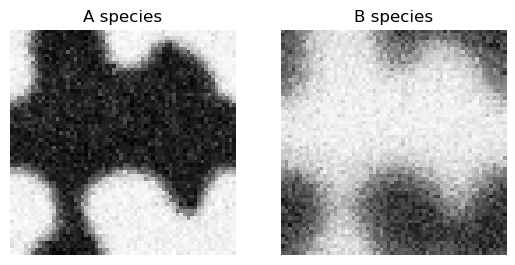

In [9]:
# @title Load and visualize ref. pattern {vertical-output: true}
ref_path = path.join(data_path, "ref")
ref_state = t.load(path.join(ref_path, "0.pt"), map_location=device)
if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state[0,0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state[0,1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

In [12]:
# @title Initialize Parameters {vertical-output: true}
# @markdown Do you want to load the last training trace ?
load_traces = True # @param {type: "boolean"}

if load_traces:
  DA_vals = np.load(path.join(data_path, "res", "DA_vals.npy")).tolist()
  DB_vals = np.load(path.join(data_path, "res", "DB_vals.npy")).tolist()
  losses = np.load(path.join(data_path, "res", "losses.npy")).tolist()
  grads_DA = np.load(path.join(data_path, "res", "grads_DA.npy")).tolist()
  grads_DB = np.load(path.join(data_path, "res", "grads_DB.npy")).tolist()

  DA = t.tensor(DA_vals[-1], device=device)
  DB = t.tensor(DB_vals[-1], device=device)

else:
  DA = t.tensor(np.load(path.join(ref_path, "DA_vals.npy"))[0], device=device)
  DB = t.tensor(np.load(path.join(ref_path, "DB_vals.npy"))[0], device=device)

  DB_vals = [DB.detach().cpu().numpy()]
  DA_vals = [DA.detach().cpu().numpy()]
  losses = []
  grads_DB = []
  grads_DA = []

In [13]:
# @title Set hyperparameters
k1 = t.tensor(0.98, device=device)
k2 = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
gamma = 0.005
N = 50

In [29]:
# @title Run gradient optimization {vertical-output: true}
# @markdown choose the number of gradient steps to run
num_gradient_steps = 3000 # @param {type: "integer"}

for i in tqdm(range(num_gradient_steps)):
    X = ref_state.detach().clone()

    DB.requires_grad_()
    DA.requires_grad_()

    # Make predictions for this batch
    for sim_step in range(500):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)

    # Compute the loss and its gradients
    loss = loss_fn(ref_state, X)
    grad_DB, grad_DA = t.autograd.grad(loss, (DB, DA))

    DB = DB - 0.05 * grad_DB
    DA = DA - 0.05 * grad_DA

    with t.no_grad():
        DB = DB.clamp(0, 1)
        DA = DA.clamp(0, 1)

    DB_vals.append(DB.detach().cpu().numpy())
    DA_vals.append(DA.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())
    grads_DB.append(grad_DB.detach().cpu().numpy())
    grads_DA.append(grad_DA.detach().cpu().numpy())

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [7:21:30<00:00,  8.83s/it]  


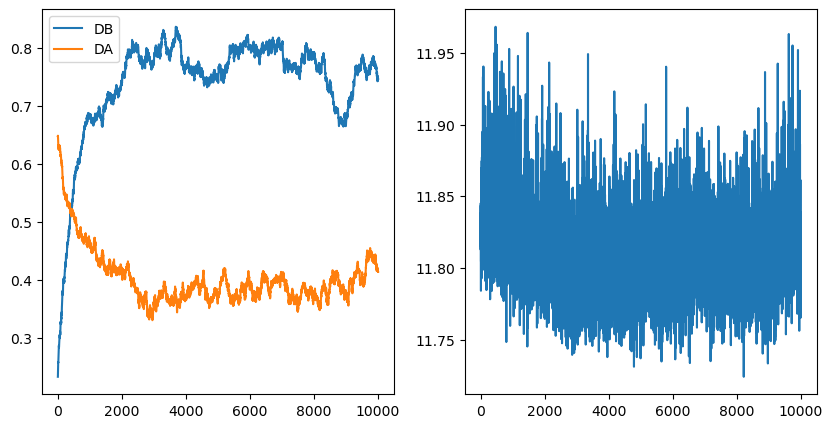

In [30]:
# @title Visualize parameter trace + loss
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].plot(DB_vals, label="DB")
axs[0].plot(DA_vals, label="DA")

axs[1].plot(losses)

axs[0].legend()
plt.show()

Text(0.5, 0, 'step')

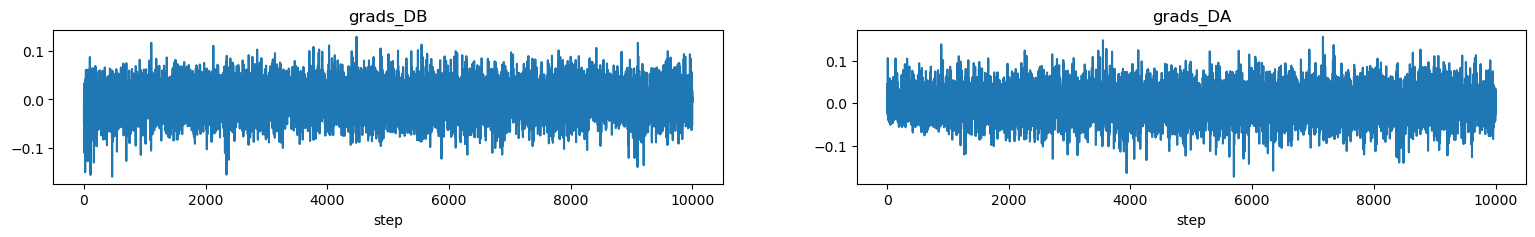

In [31]:
# @title Visualize gradient traces
fig, axs = plt.subplots(1, 2, figsize=(19,2))

axs[0].plot(grads_DB)
axs[0].set_title("grads_DB")
axs[0].set_xlabel("step")

axs[1].plot(grads_DA)
axs[1].set_title("grads_DA")
axs[1].set_xlabel("step")

In [32]:
# @title save traces
np.save(path.join(getcwd(), "joint_optim_da_db", "res", "DA_vals.npy"), np.array(DA_vals))
np.save(path.join(getcwd(), "joint_optim_da_db", "res", "DB_vals.npy"), np.array(DB_vals))
np.save(path.join(getcwd(), "joint_optim_da_db", "res", "losses.npy"), np.array(losses))
np.save(path.join(getcwd(), "joint_optim_da_db", "res", "grads_DA.npy"), np.array(grads_DA))
np.save(path.join(getcwd(), "joint_optim_da_db", "res", "grads_DB.npy"), np.array(grads_DB))

In [27]:
timestep = 6000
res_path = path.join(data_path, "res")
DA = t.tensor(DA_vals[timestep], device=device)
DB = t.tensor(DB_vals[timestep], device=device)
X = t.zeros((1, 2, 64, 64), device=device)
X[:] = 25
X[0, 0, 29:35] = 40
for sim_step in tqdm(range(50_000)):
    # run the diffusion step
    X = diffuse_STE(X, N, DA, DB)
    # run the reaction step
    X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)

np.save(path.join(res_path, f"stable_t{timestep}.npy"), X.detach().cpu().numpy())

100%|██████████| 50000/50000 [05:23<00:00, 154.49it/s]


In [28]:
timestep = 6500
res_path = path.join(data_path, "res")
DA = t.tensor(DA_vals[timestep], device=device)
DB = t.tensor(DB_vals[timestep], device=device)
X = t.zeros((1, 2, 64, 64), device=device)
X[:] = 25
X[0, 0, 29:35] = 40
for sim_step in tqdm(range(50_000)):
    # run the diffusion step
    X = diffuse_STE(X, N, DA, DB)
    # run the reaction step
    X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)

np.save(path.join(res_path, f"stable_t{timestep}.npy"), X.detach().cpu().numpy())

100%|██████████| 50000/50000 [05:15<00:00, 158.69it/s]


In [29]:
timestep = 7000
res_path = path.join(data_path, "res")
DA = t.tensor(DA_vals[timestep], device=device)
DB = t.tensor(DB_vals[timestep], device=device)
X = t.zeros((1, 2, 64, 64), device=device)
X[:] = 25
X[0, 0, 29:35] = 40
for sim_step in tqdm(range(50_000)):
    # run the diffusion step
    X = diffuse_STE(X, N, DA, DB)
    # run the reaction step
    X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)

np.save(path.join(res_path, f"stable_t{timestep}.npy"), X.detach().cpu().numpy())

100%|██████████| 50000/50000 [05:05<00:00, 163.83it/s]


In [30]:
timestep = 7500
res_path = path.join(data_path, "res")
DA = t.tensor(DA_vals[timestep], device=device)
DB = t.tensor(DB_vals[timestep], device=device)
X = t.zeros((1, 2, 64, 64), device=device)
X[:] = 25
X[0, 0, 29:35] = 40
for sim_step in tqdm(range(50_000)):
    # run the diffusion step
    X = diffuse_STE(X, N, DA, DB)
    # run the reaction step
    X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)

np.save(path.join(res_path, f"stable_t{timestep}.npy"), X.detach().cpu().numpy())

100%|██████████| 50000/50000 [05:19<00:00, 156.69it/s]


In [31]:
timestep = 8000
res_path = path.join(data_path, "res")
DA = t.tensor(DA_vals[timestep], device=device)
DB = t.tensor(DB_vals[timestep], device=device)
X = t.zeros((1, 2, 64, 64), device=device)
X[:] = 25
X[0, 0, 29:35] = 40
for sim_step in tqdm(range(50_000)):
    # run the diffusion step
    X = diffuse_STE(X, N, DA, DB)
    # run the reaction step
    X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)

np.save(path.join(res_path, f"stable_t{timestep}.npy"), X.detach().cpu().numpy())

100%|██████████| 50000/50000 [04:42<00:00, 176.69it/s]


In [32]:
timestep = 8500
res_path = path.join(data_path, "res")
DA = t.tensor(DA_vals[timestep], device=device)
DB = t.tensor(DB_vals[timestep], device=device)
X = t.zeros((1, 2, 64, 64), device=device)
X[:] = 25
X[0, 0, 29:35] = 40
for sim_step in tqdm(range(50_000)):
    # run the diffusion step
    X = diffuse_STE(X, N, DA, DB)
    # run the reaction step
    X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)

np.save(path.join(res_path, f"stable_t{timestep}.npy"), X.detach().cpu().numpy())

100%|██████████| 50000/50000 [04:47<00:00, 174.10it/s]
